# Run 'baseline' model

In [1]:
%load_ext autoreload
%autoreload 2

#from keras.layers import merge
from src.data import utils
from src.models.data import *
from src.models.model import *
from src.models.predict_model import *
from src.data.utils import get_tile_prefix

from sklearn.externals import joblib

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# base directories with data (image tiles) to be analyzed
base_dir = "../../data"
dirs = []
train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
# subdirs
dir_x = 'sat'
dir_y = 'map'

# max. number of samples (files) to analyze
max_num_x = 20

# ------------- image characteristics and augmentation -----------------------------
# size of tiles
target_size = (512,512)


#--------------- model ----------------------------------------------------
# path to & filename of model to save
trained_model_fn = '../../models/baseline_ML_model_test.pkl'

#--------------- training details / hyperparameters -----------------------------------



In [3]:
# obtain list and number of available samples (files)
file_list_x, num_x = utils.get_list_samplefiles(os.path.join(train_dir, dir_x))

# actual number of samples that will be used for training, given samples available and user's choice
num_x_use = min(num_x, max_num_x)


### Define model

In [4]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=None,
    min_samples_split=6,
    min_samples_leaf=10,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=None,
    verbose=1,
    warm_start=False,
    class_weight=None)

model_is_binary = True

### Load data

In [5]:
CLASS_DICT = get_class_dict()
# 
num_features = 4
# number of pixels per image
img_size = np.prod(target_size)
# preallocate arrays collecting features (x) and labels (y) of all samples
arr_x = np.empty((img_size * num_x_use, num_features), dtype=np.float32)
arr_y = np.empty(img_size * num_x_use, dtype=np.uint8)


for i, fn in enumerate(file_list_x[:num_x_use]):
    # read sat image tile
    x = io.imread(os.path.join(train_dir, dir_x, fn))
    # read corresponding label tile
    y = io.imread(os.path.join(train_dir, dir_y, fn))  
    # refactor labels
    y, mask = refactor_labels(x, y, class_dict=CLASS_DICT, model_is_binary=True, meta=None)
    # scale x
    x = x/255.0
    print("{0:s}: ({1:0.0f} % non-image pixels)...".format(fn, 100*np.sum(mask)/img_size))
    # copy flattened features and labels in arrays
    arr_y[i*img_size:(i+1)*img_size] = y.reshape(img_size, order = 'C')
    arr_x[i*img_size:(i+1)*img_size,:] =x.reshape((img_size, num_features), order = 'C')
    
# retain all except no_img values
good_ix = arr_y != CLASS_DICT["no_img"]
arr_x = arr_x[good_ix, :]
arr_y = arr_y[good_ix]


20180427_020504_103c_3B_0002.tif: (34 % non-image pixels)...
20180606_020625_0f1b_3B_0005.tif: (25 % non-image pixels)...
20180427_020503_103c_3B_0000.tif: (63 % non-image pixels)...
20180427_020503_103c_3B_0002.tif: (34 % non-image pixels)...
20180427_020503_103c_3B_0019.tif: (0 % non-image pixels)...
20180427_020503_103c_3B_0020.tif: (60 % non-image pixels)...
20180427_020503_103c_3B_0028.tif: (45 % non-image pixels)...
20180427_020503_103c_3B_0035.tif: (0 % non-image pixels)...
20180427_020503_103c_3B_0036.tif: (30 % non-image pixels)...
20180427_020503_103c_3B_0044.tif: (16 % non-image pixels)...
20180427_020503_103c_3B_0050.tif: (0 % non-image pixels)...
20180427_020503_103c_3B_0051.tif: (3 % non-image pixels)...
20180427_020503_103c_3B_0058.tif: (0 % non-image pixels)...
20180427_020503_103c_3B_0065.tif: (0 % non-image pixels)...
20180427_020503_103c_3B_0066.tif: (0 % non-image pixels)...
20180427_020503_103c_3B_0074.tif: (0 % non-image pixels)...
20180427_020503_103c_3B_0081.tif

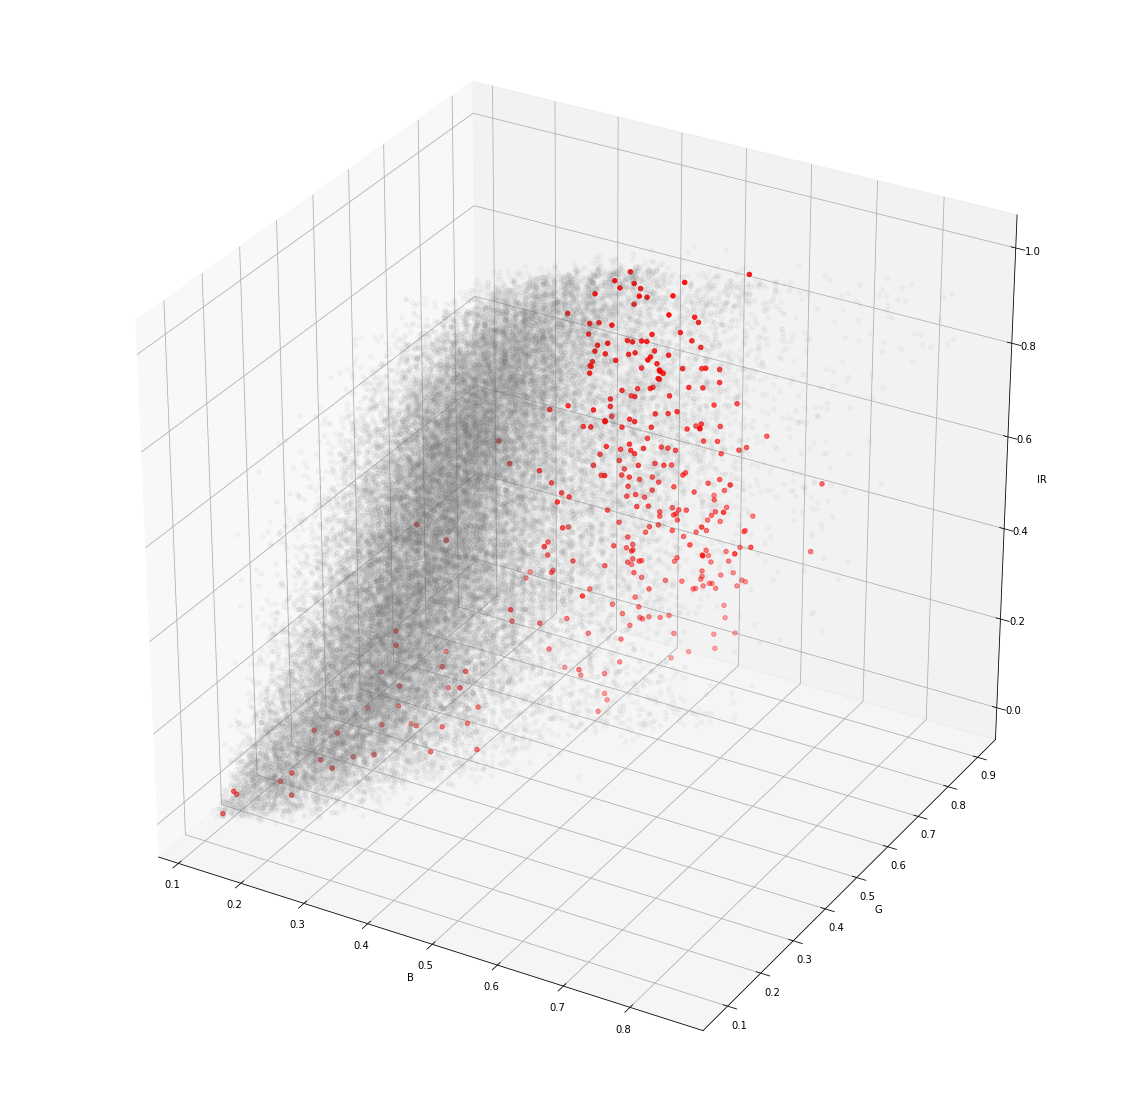

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

arr_x_plot = arr_x[::100,:]
arr_y_plot = arr_y[::100]


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ix = arr_y_plot == 40
ax.scatter(arr_x_plot[ix,0], arr_x_plot[ix,1], arr_x_plot[ix,3], c="gray", alpha=0.05)  # , c=c, marker=m
ix = arr_y_plot == 200
ax.scatter(arr_x_plot[ix,0], arr_x_plot[ix,1], arr_x_plot[ix,3], c="red")  # , c=c, marker=m


ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('IR')

plt.show()

### Run training

In [8]:
#sys.exit()
import time
t1 = time.time()
mdl.fit(arr_x, arr_y)
t2 = time.time()
print("Model fitting finished after {0:0.0f} s wall clock time".format(t2-t1))

Model fitting finished after 23.920289516448975 s wall clock time


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.7s finished


In [9]:
mdl.feature_importances_

array([0.25999409, 0.21536798, 0.31336643, 0.2112715 ])

In [12]:
# save model
joblib.dump(mdl, trained_model_fn) 

['../../models/baseline_ML_model_test.pkl']